# KarriereAI
#### A deep learning model used to predict viable career paths to a user based on their skills and interests.

#### Purpose
KarriereAI will classify the appropriate career within technology for a user from an interactive quizlet input. The quizlet is used to determine the user's skills and interests, before the model will predict a fitting career based on the input data.

#### Dataset
The dataset to be used is from the paper Skill2vec: A Machine Learning Approach for Determining the Relevant Skills from Job Description, by Van-Duyet Le et al. <a href="https://arxiv.org/pdf/1707.09751">here</a>. Containing relevant columns of job titles related to a free-text field of job descriptions describing relevant skills. 

#### Model Architecture
The main model is a feed-forward neural network (FNN) for classification, using a multi-layer-perceptron (MLP) architecture suitable for structured data classification. 

Part of engineering the main model requires preprocessing of the dataset in a natural language processing (NLP) set-up, preparing it to run through a sub-model with an encoded transformer architecture.

The main model also requires figuring out basic vs. deep MLP architecures. Additionally, figuring out whether the model should contain batch normalization, regularization and/or dropout. Lastly, experimenting with different activation functions.

Through using the NLP sub-model, the data will be vectorized to work with the MLP classifier rather than the language model.

#### Evaluation
As far as evaluation goes, a confusion matrix and an F1 score will be computed along with standard evaluation metrics like accuracy, recall and precision.

### Step 1 - Importing Libraries and Loading the Data 
We will be needing different libraries from <a href="https://keras.io/api/">Keras</a> and <a href="https://www.tensorflow.org/api_docs/python/tf">TensorFlow</a> among others to make computations on the dataset.

In [2]:
# Model processing
import sklearn
import numpy
import pandas
import tensorflow
import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from keras import layers, Sequential
from scipy import sparse
from scipy.sparse import hstack

# Other
import datetime

# For plotting
%matplotlib inline
import matplotlib as plot
import matplotlib.pyplot as pyplot

from pathlib import Path
import seaborn
seaborn.set_theme (style = "whitegrid")

%load_ext tensorboard

After importing relevant libraries, we load the dataset we wish to train the model on.

In [3]:
# Load dataset
data = pandas.read_csv ("data/mustHaveSkills.csv", header = 0, encoding ='ISO-8859-1')

# REF: Van-Duyet Le

### Step 2 - Taking a Look at the Data

To create optimal and smooth-running Python for the model we want to  study the shape of the data.

In [4]:
# Basic information about dataset
print ("Shape of dataset:", data.shape, "\n")
print ("Information about dataset:")
data.info()

Shape of dataset: (261724, 3) 

Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261724 entries, 0 to 261723
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_brief_id  261724 non-null  int64 
 1   keyword_name  261717 non-null  object
 2   job_title     261724 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


#### 1.1 String Cleanup

In [49]:
# String magic
data ['keyword_name'] = data ['keyword_name'].str.lower()
data ['job_title'] = data ['job_title'].str.lower()

# Drop duplicates
# data = data.drop_duplicates (subset = ['keyword_name', 'job_title'], keep = 'last')
data = data [data ["job_title"] != 0]
print (data.info())

# REF: Van-Duyet Le

<class 'pandas.core.frame.DataFrame'>
Index: 40934 entries, 8 to 261721
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_brief_id  40934 non-null  int64 
 1   keyword_name  40934 non-null  object
 2   job_title     40934 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


C:\Users\arege\AppData\Local\Temp\ipykernel_23760\3523098576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data ['keyword_name'] = data ['keyword_name'].str.lower()
C:\Users\arege\AppData\Local\Temp\ipykernel_23760\3523098576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data ['job_title'] = data ['job_title'].str.lower()


### Step 3 - Exploratory Data Analysis (EDA)

To know what data the model will injest, taking a closer look by constructing plots and 

#### 3.1 Plotting Jobs and Skills
##### 3.1.1 Jobs

In [6]:
# Function to count number of occurrences 
def count_items(series):
    items = series.dropna().apply(lambda x: x.split(";"))
    flat_list = [item.strip() for sublist in items for item in sublist]
    return pandas.Series(flat_list).value_counts()

# REF: Adil Shamim

In [7]:
# Count Jobs
job_count = count_items(data["job_title"])
print("Most Common Jobs:\n", job_count)

Most Common Jobs:
 software engineer                         8765
software developer                        5098
engineer                                  3616
manager                                   2824
developer                                 2454
                                          ... 
statistical programer                        1
commercial finance manager                   1
campus manager                               1
level manger or director or consultant       1
quality assurance or quality                 1
Name: count, Length: 4597, dtype: int64


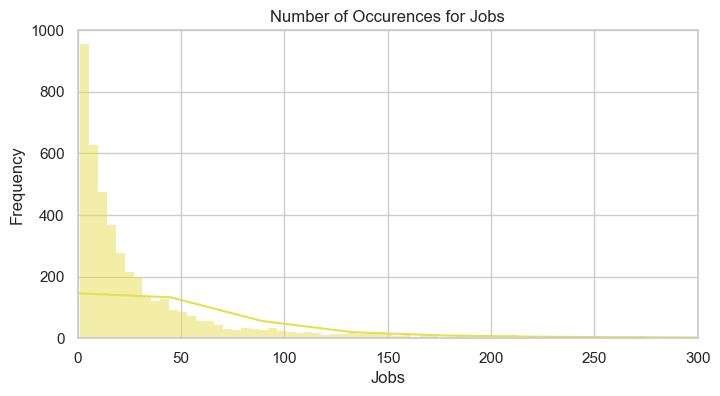

In [8]:
pyplot.figure (figsize = (8, 4))
seaborn.histplot (job_count, kde = True, color = "#e7de50")
pyplot.title ("Number of Occurences for Jobs")
pyplot.xlabel ("Jobs")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

##### 3.1.2 Skills

In [9]:
# Count Skills
skills_count = count_items(data["keyword_name"])
print("Most Common Skills:\n", skills_count)

Most Common Skills:
 java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64


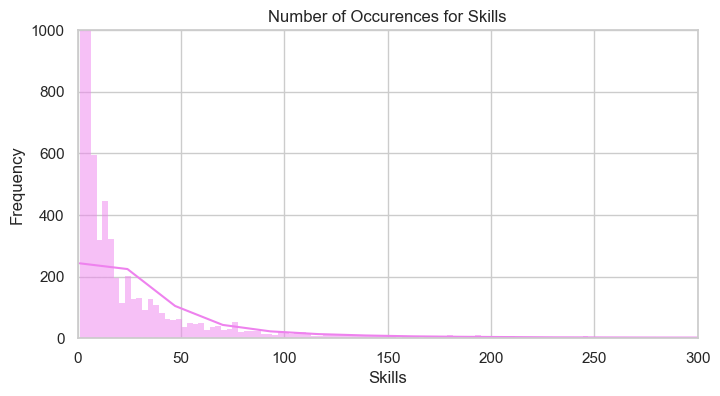

In [10]:
pyplot.figure (figsize = (8, 4))
seaborn.histplot (skills_count, kde = True, color = "violet")
pyplot.title ("Number of Occurences for Skills")
pyplot.xlabel ("Skills")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

In [11]:
skills_count

java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64

### Step 4: Preprocessing of Data

For the purpose of cleaning the dataset to make sure the model doesn't learn errors making predictions skewed.

#### 4.1 Normalization
Normalizing the job titles with less occurrences than an input threshold.

In [12]:
# Remove jobs below threshold of top 100
job_count = job_count.iloc[0:100]
print ("Job Count")
print (job_count)

Job Count
software engineer         8765
software developer        5098
engineer                  3616
manager                   2824
developer                 2454
                          ... 
statistical programmer     407
ctm                        406
staff engineer             405
senior manager             396
automation engineer        394
Name: count, Length: 100, dtype: int64


In [13]:
# Remove skills for jobs below threshold of top 100
skills_count = skills_count.iloc[0:100]
print ("Skill Count")
print (skills_count)

Skill Count
java                4588
c++                 3193
j2ee                2255
python              2177
javascript          2004
                    ... 
automation           362
e-commerce           354
computer science     352
english              349
consulting           348
Name: count, Length: 100, dtype: int64


In [14]:
data = data [data ['job_title'].isin (job_count.keys())]
data

,job_brief_id,keyword_name,job_title
1,4,php,web developer
4,4,php,product manager
8,4,html,web developer
11,4,html,product manager
15,4,css,web developer
...,...,...,...
261713,12835,c,software engineer
261716,12835,c++,software developer
261717,12835,c++,software engineer
261720,12835,c#,software developer


In [15]:
data = data [data ['keyword_name'].isin (skills_count.keys())]
data

,job_brief_id,keyword_name,job_title
8,4,html,web developer
11,4,html,product manager
15,4,css,web developer
18,4,css,product manager
22,4,mysql,web developer
...,...,...,...
261713,12835,c,software engineer
261716,12835,c++,software developer
261717,12835,c++,software engineer
261720,12835,c#,software developer


In [16]:
# Setup for Usable Data
dataset = data.groupby (['job_brief_id', 'job_title'])['keyword_name'].apply(list)
print (dataset.head())

job_brief_id  job_title      
4             product manager                                   [html, css, mysql]
              web developer                                     [html, css, mysql]
6             architect          [java, j2ee, jee, j2me, javase, javaee, javame...
              consultant         [java, j2ee, jee, j2me, javase, javaee, javame...
              developer          [java, j2ee, jee, j2me, javase, javaee, javame...
Name: keyword_name, dtype: object


In [17]:
# # Drop the id column which is unnecessary for training
dataframe = dataset.droplevel(0)

# Turn this into the correct type
dataframe = dataframe.to_frame("skills")
dataframe = dataframe.reset_index()
dataframe

,job_title,skills
0,product manager,"[html, css, mysql]"
1,web developer,"[html, css, mysql]"
2,architect,"[java, j2ee, jee, j2me, javase, javaee, javame..."
3,consultant,"[java, j2ee, jee, j2me, javase, javaee, javame..."
4,developer,"[java, j2ee, jee, j2me, javase, javaee, javame..."
...,...,...
10478,quality assurance,"[test, python, c++]"
10479,quality engineer,"[test, python, c++]"
10480,account manager,[sales]
10481,software developer,"[c, c++, c#]"


#### 4.2 Encoding Input

Encoding the input for the model, turning text values into numerical values for processing.

In [18]:
skills_list = skills_count.keys ().to_list ()
titles_list = job_count.keys ().to_list ()


def map_skills_to_index (skills):
    return list (map (lambda skill: skills_list.index(skill), skills))

def map_title_to_index (title):
    return titles_list.index(title)

In [19]:
def update_values(row):
    if isinstance(row, str):
        return map_title_to_index(row)
    else:
        return map_skills_to_index(row)

dataframe = dataframe.map(update_values) #row: (map_skills_to_index(row)))

dataframe

,job_title,skills
0,17,"[23, 20, 76]"
1,46,"[23, 20, 76]"
2,29,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
3,5,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
4,4,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
...,...,...
10478,28,"[93, 3, 1]"
10479,53,"[93, 3, 1]"
10480,19,[22]
10481,1,"[13, 1, 8]"


In [20]:
encoder = keras.layers.CategoryEncoding (
    num_tokens = skills_count.count(),
    output_mode = "multi_hot", 
        # there is an option to normalize it ^ using count (????????????) or add bodies to certain values
        # using count_weights
        # not possible while using multi-hot encoding or one-hot encoding
)

In [57]:
feature_names = ["job_title", "skills"]

def encode_skills(row):
    return encoder(row).numpy()

#dataframe["skills"] = 
feature_skills = list(map(encode_skills, dataframe["skills"].to_list()))
feature_skills

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 

In [ ]:
feature_titles = dataframe["job_title"]

dataframe_skills = pandas.DataFrame(data = feature_skills)
dataframe_titles = pandas.DataFrame(data = feature_titles)
model_dataframe = dataframe_titles.merge(dataframe_skills, left_index=True, right_index=True)
model_dataframe

,job_title,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10478,28,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10479,53,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10480,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10481,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 5 - Building the Model

Building the FFN model, and training it.

In [ ]:
#from datasets import Dataset

#model_dataset = Dataset.from_pandas(model_dataframe)
#model_dataset
# tensorflow.data.experimental.cardinality(model_dataset)

# print(model_dataset)

Dataset({
    features: ['job_title', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
    num_rows: 10483
})

In [122]:
#import torch

#model_dataset = tensorflow.data.Dataset.from_tensors(model_dataframe)
#model_dataset
#model_tensor = torch.utils.data.Dataset(model_dataframe.values)

TypeError: Dataset() takes no arguments

#### 5.1 Training, Validation and Test Sets

In [142]:
model_dataset = tensorflow.data.Dataset.from_tensor_slices(model_dataframe.values)

In [154]:
# Section off testing dataset from training data
train_dataset, test_dataset = tensorflow.keras.utils.split_dataset (
    model_dataset,
    left_size = 0.70,
)

print(train_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(101,), dtype=tf.float64, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(101,), dtype=tf.float64, name=None)>


#### 5.2 Training the Model

In [ ]:
model = Sequential([
    # keras.Input (shape = (100, )),
    layers.Dropout (0.1), # important for our dataset! 
    layers.Dense (16, activation = 'relu'),
    layers.Dense (16, activation = 'relu'),
    layers.Dense (100)
])

# model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam')
model.compile (loss = 'hinge', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

model.fit (feature_skills, feature_titles,
          epochs = 30, 
          batch_size = 1, 
          validation_split = 0.2,
          callbacks = [tensorboard_callback])

Epoch 1/30


ValueError: None values not supported.

In [ ]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 151)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,378 (44.45 KB)

 Trainable params: 3,792 (14.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,586 (29.64 KB)

: 

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 20476), started 1 day, 13:53:40 ago. (Use '!kill 20476' to kill it.)

: 

### Step 6 - Evaluation

: 

#### 6.1 Confusion Matrix

In [ ]:
# Predict on the test set
# y_pred = model.predict(X_train)

: 

In [ ]:
# # Confusion matrix
# cm = confusion_matrix(y_train, y_pred)
# plot.figure(figsize = (10, 8))
# seaborn.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
#             xticklabels = target_encoder.classes_,
#             yticklabels = target_encoder.classes_)
# plot.xlabel("Predicted")
# plot.ylabel("Actual")
# plot.title("Confusion Matrix")
# plot.show()

: 

#### 6.2 F1-Score

: 

#### 6.3 Precision, Accuracy, Recall

: 